<a href="https://colab.research.google.com/github/ziatdinovmax/pyroVED/blob/main/examples/ssrVAE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Semi-supervised VAE for data with orientational disorder


---

This notebook demonstrates how to use a variational autoencoder (VAE) to generalize from a small subset of labeled data with the weak orientational disorder to a large unlabelled data set with a much stronger orientational disorder.

---



Prepared by Maxim Ziatdinov

E-mail: ziatdinovmax@gmail.com

In [2]:
#@title Installations
!pip install -q pyroved kornia

     |████████████████████████████████| 276kB 15.1MB/s 
     |████████████████████████████████| 634kB 14.0MB/s 


In [3]:
#@title Imports
import pyroved as pv

import kornia as K
import cv2
from torchvision.utils import make_grid
import torch
import torch.nn as nn
import torch.tensor as tt
import numpy as np
import matplotlib.pyplot as plt

In [4]:
#@title Helper function
rs = lambda x: cv2.resize(x, (64, 64), cv2.INTER_CUBIC)

def get_data():
    !gdown -q https://drive.google.com/uc?id=1AyGHVflbIjzinkKBURHNVDx1wWg9JixB
    !unzip -o -qq cards.zip
    card1 = rs(cv2.imread("cards/card1.JPG", cv2.IMREAD_GRAYSCALE))
    card2 = rs(cv2.imread("cards/card2.JPG", cv2.IMREAD_GRAYSCALE))
    card3 = rs(cv2.imread("cards/card3.JPG", cv2.IMREAD_GRAYSCALE))
    card4 = rs(cv2.imread("cards/card4.JPG", cv2.IMREAD_GRAYSCALE))
    card1 = tt(1 - card1 / card1.max())
    card2 = tt(1 - card2 / card2.max())
    card3 = tt(1 - card3 / card3.max())
    card4 = tt(1 - card4 / card4.max())
    return card1, card2, card3, card4


def transform_images(*args, **kwargs):
    card1, card2, card3, card4 = args
    a = kwargs.get("angle")
    t = kwargs.get("translation")
    s = kwargs.get("shear")
    z = kwargs.get("scale")
    n_samples = kwargs.get("samples", 3000)
    torch.manual_seed(kwargs.get("seed", 0))
    # Define transform(s)
    transform = nn.Sequential(
        K.augmentation.CenterCrop((48, 48)),
        K.augmentation.RandomAffine(a, translate=t, shear=[-s, s, -s, s], scale=z, p=1),
    )
    # Apply random transformations to a batch of 3000 images for each card type
    cards1 = transform(card1[None, None].repeat_interleave(n_samples, dim=0))
    cards2 = transform(card2[None, None].repeat_interleave(n_samples, dim=0))
    cards3 = transform(card3[None, None].repeat_interleave(n_samples, dim=0))
    cards4 = transform(card4[None, None].repeat_interleave(n_samples, dim=0))

    # Concatenate (this is our training set)
    cards_all = torch.cat([cards1, cards2, cards3, cards4]).squeeze().float()
    labels_all = torch.cat([torch.zeros(n_samples), torch.ones(n_samples),
                           2*torch.ones(n_samples), 3*torch.ones(n_samples)])
    return cards_all.flatten(1), pv.utils.to_onehot(labels_all.long(), n=4)


def plot_manifolds(model):   
    fig, axes = plt.subplots(2, 2, figsize=(12, 12),
                            subplot_kw={'xticks':[], 'yticks':[]},
                            gridspec_kw=dict(hspace=0.1, wspace=0.05))
    for i, ax in enumerate(axes.flat):
        manifold = model.manifold2d(d=9, label=i, plot=False)
        grid = make_grid(manifold[:, None], nrow=9, pad_value=.5)
        ax.imshow(grid[0], cmap='viridis')
    plt.show()

## Training data

We are going to make our own training data from playing card suits, with monochrome clubs, spades, diamonds, and hearts.  Using a digitized symbols from Word as a starting point, we apply a set of affine transforms including rotation, shear, translation, and scale to prepare our data sets. Note that we are going to apply different sets of distortions to labeled and unlabeled parts of our data.

In [5]:
cards = get_data()

In [6]:
# Labeled set (no transaltion, small rotations)
X_sup, y_sup = transform_images(
    *cards,
    shear=15, scale=(1, 1.3), angle=4, translation=None, 
    samples=200, seed=0)
# Unlabeled set (translation, large rotations)
X_unsup, _ = transform_images(
    *cards,
    shear=15, scale=(1, 1.3), angle=60, translation=0.1, 
    samples=3000, seed=1)
# Validation set (same as unlabeled, but using different seed)
X_val, y_val = transform_images(
    *cards,
    shear=15, scale=(1, 1.3), angle=60, translation=0.1, 
    samples=1000, seed=2)

Here's the supervised part of our training set:

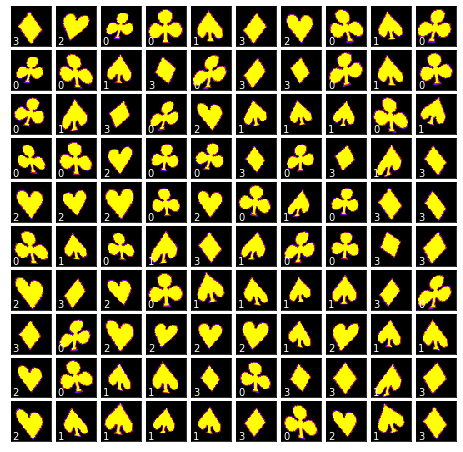

In [7]:
fig, axes = plt.subplots(10, 10, figsize=(8, 8),
                         subplot_kw={'xticks':[], 'yticks':[]},
                         gridspec_kw=dict(hspace=0.1, wspace=0.1))

for ax in axes.flat:
    i = torch.randint(0, len(X_sup), size=(1,))
    im = X_sup[i]
    ax.imshow(im.view(48, 48), cmap='gnuplot', interpolation='nearest')
    ax.text(0.05, 0.05, str(y_sup[i].argmax().item()),
            transform=ax.transAxes, color='white')

... and this is the unsupervised one. Note that here we have much larger orientational disorder as long as random offsets (in other words, the rotations and translations of the unlabeled data come from a different distribution than those of the labeled data!)

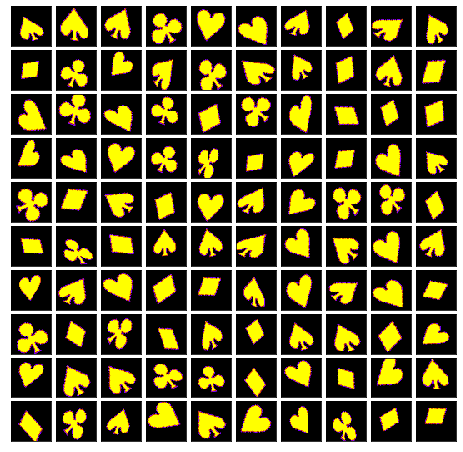

In [8]:
fig, axes = plt.subplots(10, 10, figsize=(8, 8),
                         subplot_kw={'xticks':[], 'yticks':[]},
                         gridspec_kw=dict(hspace=0.1, wspace=0.1))

for ax in axes.flat:
    i = torch.randint(0, len(X_unsup), size=(1,))
    im = X_unsup[i]
    ax.imshow(im.view(48, 48), cmap='gnuplot', interpolation='nearest')

Next, we create dataloaders:

In [9]:
(loader_unsup, loader_sup,
 loader_val) = pv.utils.init_ssvae_dataloaders(
     X_unsup, (X_sup, y_sup), (X_val, y_val), batch_size=64)

In [10]:
r = len(loader_sup) / (len(loader_unsup) + len(loader_sup))
print("Ratio of labeled data: {}".format(r))

Ratio of labeled data: 0.06467661691542288


## Train ss-(tr)VAE model

Finally, we will train a semi supervised (ss) VAE model. The goal is to use a limited amount (~6%) of labeled data with small positional (orientation+translation) disorder to categorize large volumes of unlabeled data characterized by a (much) higher positional disorder. During the training, we are also going to enforce **t**ranslational and **r**otational invariance (hence, *ss-tr*VAE)

Epoch: 1 Training loss: 815.1063, Test accuracy: 0.2955
Epoch: 2 Training loss: 515.5246, Test accuracy: 0.4873
Epoch: 3 Training loss: 474.9818, Test accuracy: 0.4790
Epoch: 4 Training loss: 430.4135, Test accuracy: 0.6010
Epoch: 5 Training loss: 400.6476, Test accuracy: 0.5870
Epoch: 6 Training loss: 380.8723, Test accuracy: 0.5913
Epoch: 7 Training loss: 365.4645, Test accuracy: 0.5970
Epoch: 8 Training loss: 355.3301, Test accuracy: 0.5765
Epoch: 9 Training loss: 342.8265, Test accuracy: 0.5743
Epoch: 10 Training loss: 332.9497, Test accuracy: 0.5887


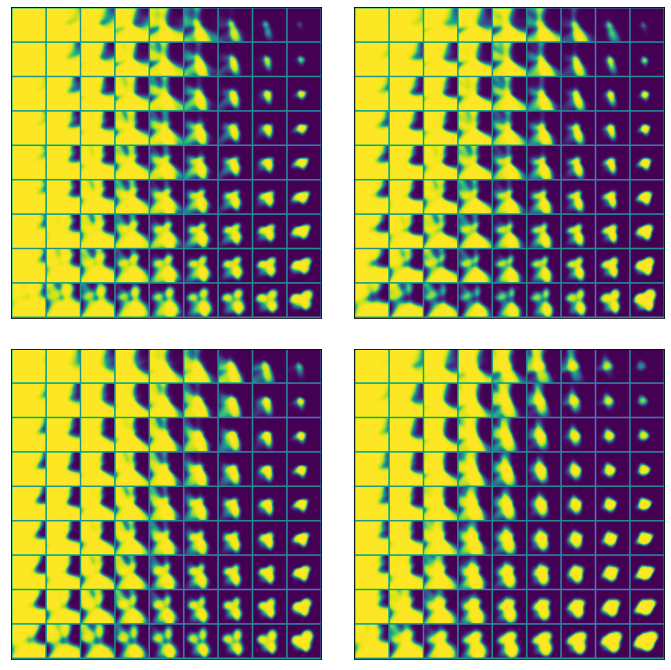

Epoch: 11 Training loss: 324.5559, Test accuracy: 0.5978
Epoch: 12 Training loss: 313.4967, Test accuracy: 0.6282
Epoch: 13 Training loss: 304.3693, Test accuracy: 0.6538
Epoch: 14 Training loss: 298.0469, Test accuracy: 0.6455
Epoch: 15 Training loss: 288.6888, Test accuracy: 0.7175
Epoch: 16 Training loss: 284.2469, Test accuracy: 0.7595
Epoch: 17 Training loss: 276.8166, Test accuracy: 0.7805
Epoch: 18 Training loss: 273.1048, Test accuracy: 0.8025
Epoch: 19 Training loss: 263.8247, Test accuracy: 0.8225
Epoch: 20 Training loss: 259.5970, Test accuracy: 0.8257


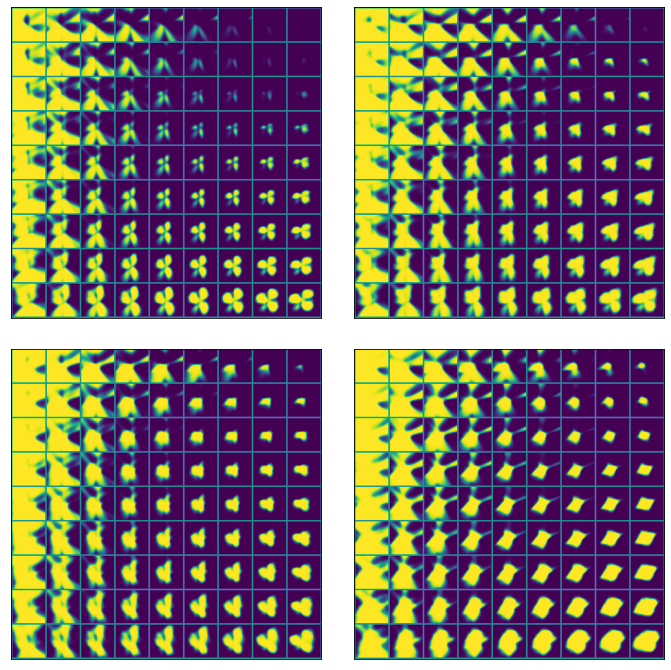

Epoch: 21 Training loss: 255.9755, Test accuracy: 0.8420
Epoch: 22 Training loss: 255.9540, Test accuracy: 0.8427
Epoch: 23 Training loss: 250.0046, Test accuracy: 0.8250
Epoch: 24 Training loss: 246.7872, Test accuracy: 0.8498
Epoch: 25 Training loss: 242.0924, Test accuracy: 0.8502
Epoch: 26 Training loss: 239.6373, Test accuracy: 0.8413
Epoch: 27 Training loss: 239.9990, Test accuracy: 0.8468
Epoch: 28 Training loss: 234.8977, Test accuracy: 0.8590
Epoch: 29 Training loss: 236.1272, Test accuracy: 0.8522
Epoch: 30 Training loss: 236.4070, Test accuracy: 0.8520


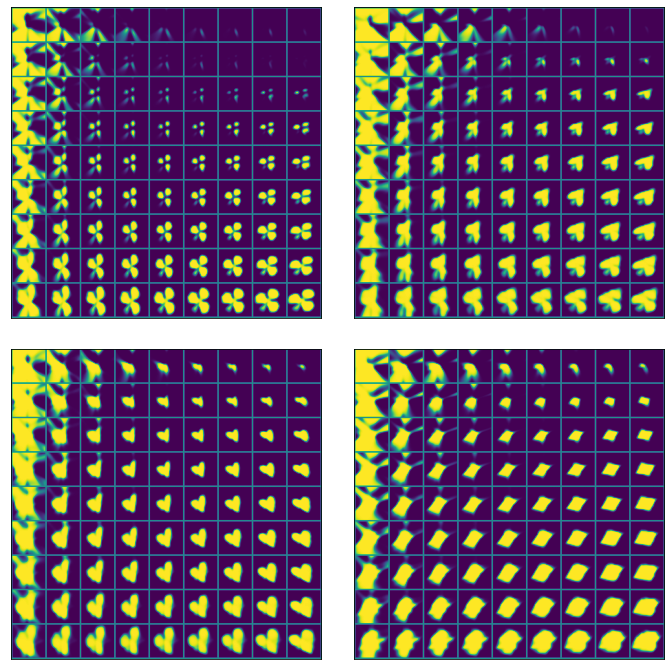

Epoch: 31 Training loss: 230.3972, Test accuracy: 0.8552
Epoch: 32 Training loss: 228.8917, Test accuracy: 0.8370
Epoch: 33 Training loss: 227.2457, Test accuracy: 0.8515
Epoch: 34 Training loss: 225.2078, Test accuracy: 0.8565
Epoch: 35 Training loss: 224.2240, Test accuracy: 0.8552
Epoch: 36 Training loss: 224.4155, Test accuracy: 0.8550
Epoch: 37 Training loss: 219.7176, Test accuracy: 0.8568
Epoch: 38 Training loss: 217.8670, Test accuracy: 0.8575
Epoch: 39 Training loss: 216.8815, Test accuracy: 0.8502
Epoch: 40 Training loss: 219.4657, Test accuracy: 0.8545


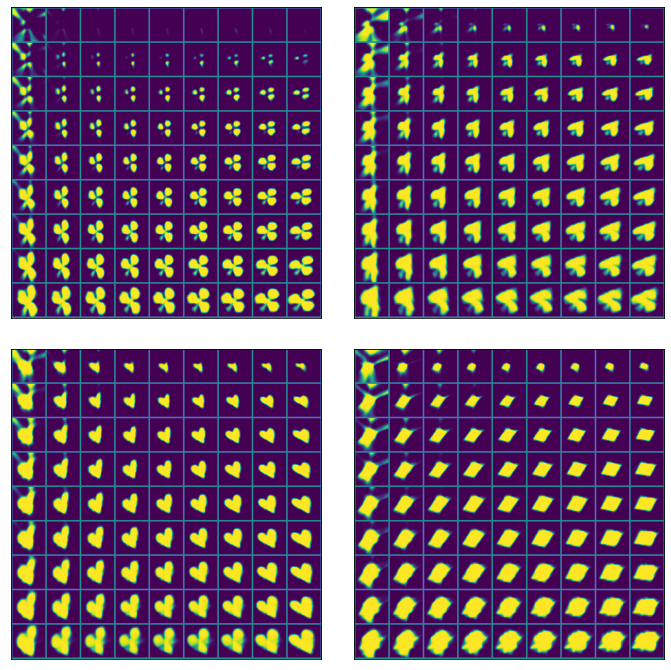

Epoch: 41 Training loss: 217.8562, Test accuracy: 0.8568
Epoch: 42 Training loss: 212.6528, Test accuracy: 0.8565
Epoch: 43 Training loss: 213.6921, Test accuracy: 0.8580
Epoch: 44 Training loss: 212.5386, Test accuracy: 0.8600
Epoch: 45 Training loss: 207.4686, Test accuracy: 0.8628
Epoch: 46 Training loss: 210.6726, Test accuracy: 0.8615
Epoch: 47 Training loss: 211.6825, Test accuracy: 0.8615
Epoch: 48 Training loss: 208.4066, Test accuracy: 0.8492
Epoch: 49 Training loss: 207.6915, Test accuracy: 0.8632
Epoch: 50 Training loss: 207.4022, Test accuracy: 0.8588


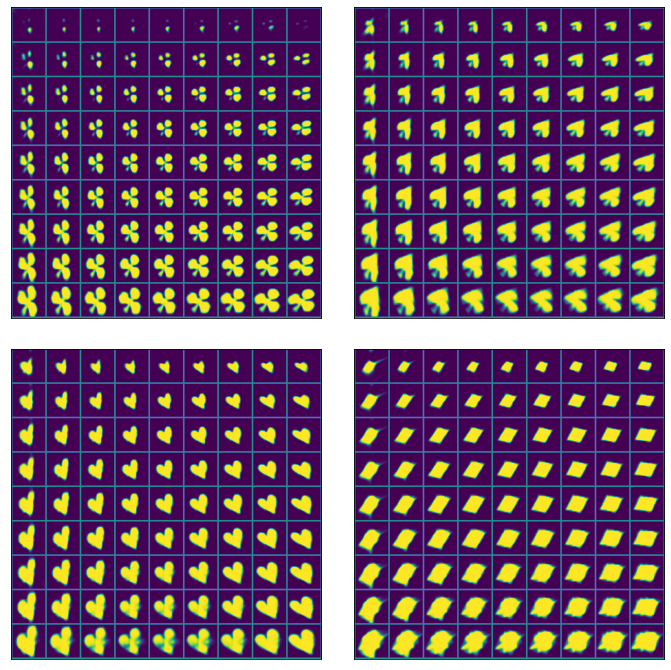

Epoch: 51 Training loss: 207.3918, Test accuracy: 0.8590
Epoch: 52 Training loss: 200.4399, Test accuracy: 0.8652
Epoch: 53 Training loss: 201.3252, Test accuracy: 0.8628
Epoch: 54 Training loss: 206.7284, Test accuracy: 0.8612
Epoch: 55 Training loss: 202.4472, Test accuracy: 0.8615
Epoch: 56 Training loss: 200.3016, Test accuracy: 0.8628
Epoch: 57 Training loss: 197.8234, Test accuracy: 0.8650
Epoch: 58 Training loss: 195.9449, Test accuracy: 0.8652
Epoch: 59 Training loss: 197.1680, Test accuracy: 0.8735
Epoch: 60 Training loss: 194.1432, Test accuracy: 0.8672


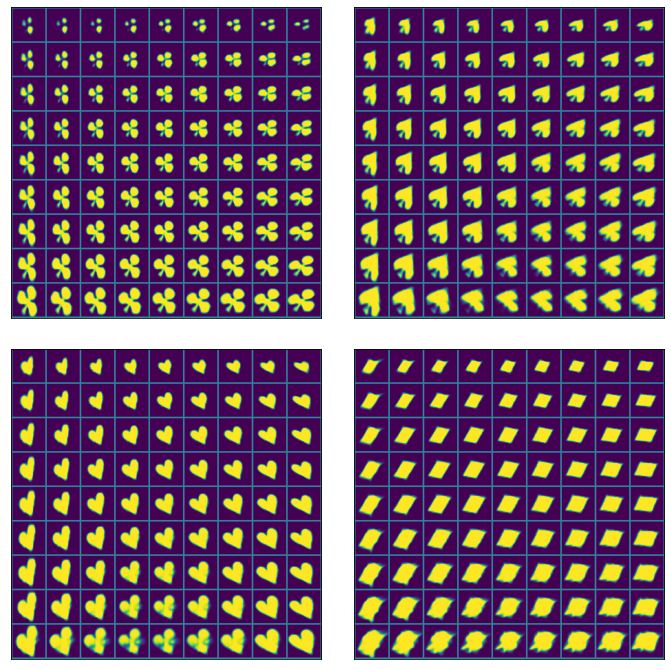

Epoch: 61 Training loss: 197.1763, Test accuracy: 0.8595
Epoch: 62 Training loss: 190.6221, Test accuracy: 0.8680
Epoch: 63 Training loss: 193.8508, Test accuracy: 0.8690
Epoch: 64 Training loss: 186.9852, Test accuracy: 0.8710
Epoch: 65 Training loss: 188.5363, Test accuracy: 0.8712
Epoch: 66 Training loss: 184.8674, Test accuracy: 0.8682
Epoch: 67 Training loss: 187.1882, Test accuracy: 0.8678
Epoch: 68 Training loss: 186.2316, Test accuracy: 0.8705
Epoch: 69 Training loss: 196.1505, Test accuracy: 0.8475
Epoch: 70 Training loss: 188.8255, Test accuracy: 0.8678


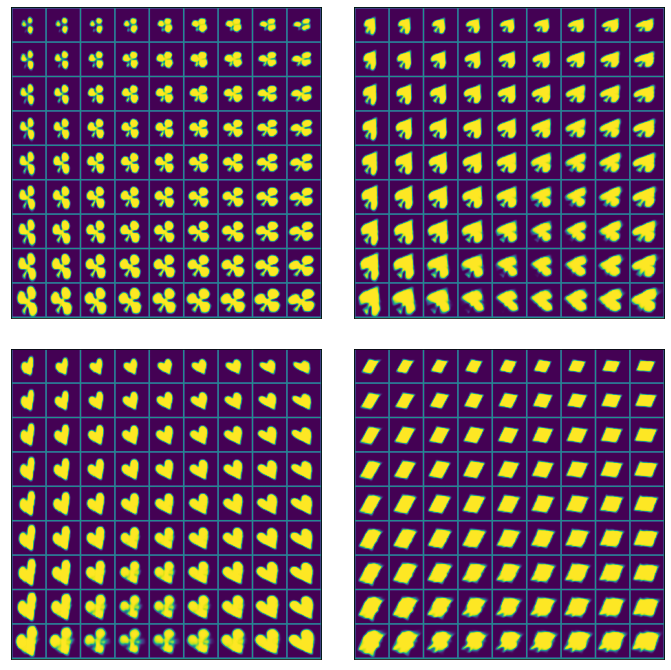

Epoch: 71 Training loss: 186.8408, Test accuracy: 0.8648
Epoch: 72 Training loss: 180.7464, Test accuracy: 0.8680
Epoch: 73 Training loss: 178.2130, Test accuracy: 0.8688
Epoch: 74 Training loss: 185.0369, Test accuracy: 0.8688
Epoch: 75 Training loss: 177.6164, Test accuracy: 0.8620
Epoch: 76 Training loss: 182.4045, Test accuracy: 0.8732
Epoch: 77 Training loss: 177.4607, Test accuracy: 0.8700
Epoch: 78 Training loss: 176.7494, Test accuracy: 0.8670
Epoch: 79 Training loss: 186.0374, Test accuracy: 0.8652
Epoch: 80 Training loss: 181.9551, Test accuracy: 0.8698


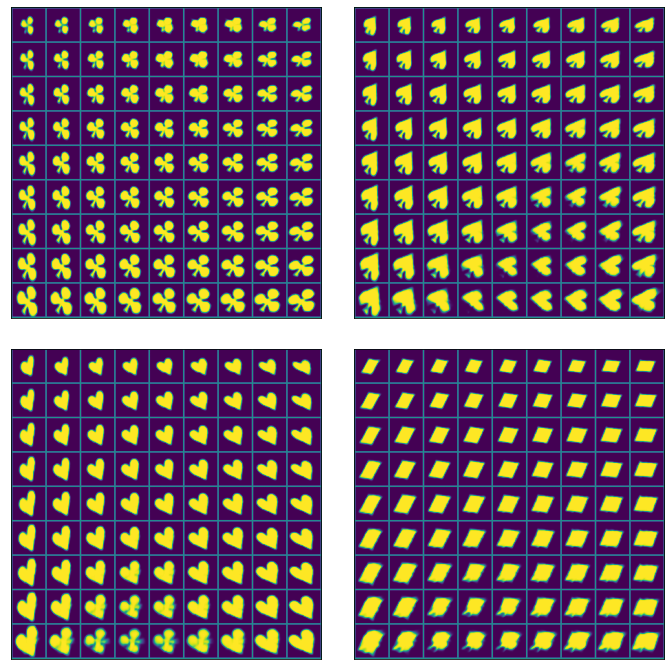

In [11]:
data_dim = (48, 48)
latent_dim = 2
num_classes = 4 
coord = 3  # add 3 "special" latent variables to enforce rotational and translational invariance

# Initialize model
ssvae = pv.models.sstrVAE(
    data_dim, latent_dim, num_classes, coord,
    dx_prior=.1)

# Initialize trainer
trainer = pv.trainers.auxSVItrainer(ssvae)

# We're going to ramp-up KL weight from 1 to 2 in the first 30 epochs
kl_scale = torch.linspace(1, 2, 30)
# Train model for n epochs
for e in range(80):
    sc = kl_scale[e] if e < len(kl_scale) else kl_scale[-1]
    trainer.step(loader_unsup, loader_sup, loader_val,
                 aux_loss_multiplier=30, scale_factor=sc)
    trainer.print_statistics()
    # Plot learned altent manifolds every 10 epoch
    if (e+1) % 10 == 0:
        plot_manifolds(ssvae)

Looks like we achieved ~88% accuracy with only ~6% of the data labeled! Furthermore, we were able to disentangle two main factors of data variation (beyond rotations and translations), namely, scale and shear deformation, which are encoded in the first (top to bottom) and second (left to right) latent variables. 

We can also plot traversals of the learned manifold where the horizontal direction corresponds to one of the continuous latent variables (while the other one is fixed at 0) and the vertical direction corresponds to the categorical variable:

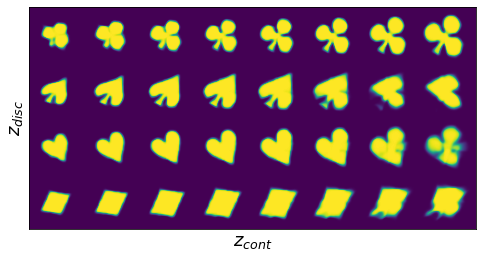

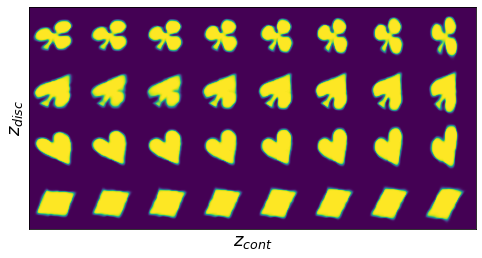

In [12]:
for i in range(2):
    ssvae.manifold_traversal(8, i, cmap='viridis')